# 概述

上一节我们研究了资源部署优化的方法，通过使用单GPU和分布式部署，提升模型训练的效率。本节我们依旧横向展开"横纵式"，如 **图1** 所示，探讨在手写数字识别任务中，为了保证模型的真实效果，在模型训练部分，对模型进行一些调试和优化的方法。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/0f94e16e03f34223903319eb50c8c09687d203f0e718491bbc7c4fc1b2a88585" width="1000" hegiht="" ></center>
<center>图1：“横纵式”教学法 — 训练过程</center>
<br></br>

训练过程优化思路主要有如下五个关键环节：

**1. 计算分类准确率，观测模型训练效果。**

交叉熵损失函数只能作为优化目标，无法直接准确衡量模型的训练效果。准确率可以直接衡量训练效果，但由于其离散性质，不适合做为损失函数优化神经网络。
    
**2. 检查模型训练过程，识别潜在问题。**

如果模型的损失或者评估指标表现异常，通常需要打印模型每一层的输入和输出来定位问题，分析每一层的内容来获取错误的原因。
    
**3. 加入校验或测试，更好评价模型效果。**

理想的模型训练结果是在训练集和验证集上均有较高的准确率，如果训练集的准确率低于验证集，说明网络训练程度不够；如果训练集的准确率高于验证集，可能是发生了过拟合现象。通过在优化目标中加入正则化项的办法，解决过拟合的问题。
    
**4. 加入正则化项，避免模型过拟合。**

飞桨框架支持为整体参数加入正则化项，这是通常的做法。此外，飞桨框架也支持为某一层或某一部分的网络单独加入正则化项，以达到精细调整参数训练的效果。

**5. 可视化分析。**

用户不仅可以通过打印或使用matplotlib库作图，飞桨还提供了更专业的可视化分析工具VisualDL，提供便捷的可视化分析方法。

# 计算模型的分类准确率

准确率是一个直观衡量分类模型效果的指标，由于这个指标是离散的，因此不适合作为损失来优化。通常情况下，交叉熵损失越小的模型，分类的准确率也越高。基于分类准确率，我们可以公平地比较两种损失函数的优劣，例如在【手写数字识别】之损失函数章节中均方误差和交叉熵的比较。

使用飞桨提供的计算分类准确率API，可以直接计算准确率。

> *class* paddle.metric.Accuracy

该API的输入参数input为预测的分类结果predict，输入参数label为数据真实的label。飞桨还提供了更多衡量模型效果的计算指标，详细可以查看paddle.meric包下面的API。

在下述代码中，我们在模型前向计算过程forward函数中计算分类准确率，并在训练时打印每个批次样本的分类准确率。

In [1]:
# 加载相关库
import os
import random
import paddle
import numpy as np
from PIL import Image
import gzip
import json


# 定义数据集读取器
def load_data(mode='train'):

    # 读取数据文件
    datafile = './work/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    data = json.load(gzip.open(datafile))
    # 读取数据集中的训练集，验证集和测试集
    train_set, val_set, eval_set = data

    # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
    IMG_ROWS = 28
    IMG_COLS = 28
    # 根据输入mode参数决定使用训练集，验证集还是测试
    if mode == 'train':
        imgs = train_set[0]
        labels = train_set[1]
    elif mode == 'valid':
        imgs = val_set[0]
        labels = val_set[1]
    elif mode == 'eval':
        imgs = eval_set[0]
        labels = eval_set[1]
    # 获得所有图像的数量
    imgs_length = len(imgs)
    # 验证图像数量和标签数量是否一致
    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(
                  len(imgs), len(labels))

    index_list = list(range(imgs_length))

    # 读入数据时用到的batchsize
    BATCHSIZE = 100

    # 定义数据生成器
    def data_generator():
        # 训练模式下，打乱训练数据
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        # 按照索引读取数据
        for i in index_list:
            # 读取图像和标签，转换其尺寸和类型
            img = np.reshape(imgs[i], [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(labels[i], [1]).astype('int64')
            imgs_list.append(img) 
            labels_list.append(label)
            # 如果当前数据缓存达到了batch size，就返回一个批次数据
            if len(imgs_list) == BATCHSIZE:
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据缓存列表
                imgs_list = []
                labels_list = []

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator

In [2]:
# 定义模型结构
import paddle.nn.functional as F
from paddle.nn import Conv2D, MaxPool2D, Linear

# 多层卷积神经网络实现
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
         
        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，池化核的大小kernel_size为2，池化步长为2
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，池化核的大小kernel_size为2，池化步长为2
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        # 定义一层全连接层，输出维度是10
        self.fc = Linear(in_features=980, out_features=10)
         
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
    def forward(self, inputs, label):
        x = self.conv1(inputs)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.reshape(x, [x.shape[0], 980])
        x = self.fc(x)
        if label is not None:
           acc = paddle.metric.accuracy(input=x, label=label)
           return x, acc
        else:
            return x

#调用加载数据的函数
train_loader = load_data('train')

#在使用GPU机器时，可以将use_gpu变量设置成True
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

#仅优化算法的设置有所差别
def train(model):
    model = MNIST()
    model.train()
    
    # 四种优化算法的设置方案，可以逐一尝试效果
    # opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.9, parameters=model.parameters())
    # opt = paddle.optimizer.Adagrad(learning_rate=0.01, parameters=model.parameters())
    opt = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())
    
    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts, acc = model(images, labels)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
                
            #后向传播，更新参数，消除梯度的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
#创建模型    
model = MNIST()
#启动训练过程
train(model)

loading mnist dataset from ./work/mnist.json.gz ......


W0111 17:28:37.697688 319250 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.3, Runtime API Version: 12.0
W0111 17:28:37.698868 319250 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


epoch: 0, batch: 0, loss is: 2.5176801681518555, acc is 0.2199999988079071
epoch: 0, batch: 200, loss is: 0.22583630681037903, acc is 0.9200000166893005
epoch: 0, batch: 400, loss is: 0.06658145040273666, acc is 0.9800000190734863
epoch: 1, batch: 0, loss is: 0.15673115849494934, acc is 0.9599999785423279
epoch: 1, batch: 200, loss is: 0.1565537303686142, acc is 0.9800000190734863
epoch: 1, batch: 400, loss is: 0.15611395239830017, acc is 0.9599999785423279
epoch: 2, batch: 0, loss is: 0.023068638518452644, acc is 0.9900000095367432
epoch: 2, batch: 200, loss is: 0.0956333577632904, acc is 0.9700000286102295
epoch: 2, batch: 400, loss is: 0.05429626628756523, acc is 0.9700000286102295
epoch: 3, batch: 0, loss is: 0.11658403277397156, acc is 0.9700000286102295
epoch: 3, batch: 200, loss is: 0.12490040063858032, acc is 0.9800000190734863
epoch: 3, batch: 400, loss is: 0.0313369445502758, acc is 0.9900000095367432
epoch: 4, batch: 0, loss is: 0.07334521412849426, acc is 0.9800000190734863

# 检查模型训练过程，识别潜在训练问题

使用飞桨动态图编程可以方便的查看和调试训练的执行过程。在网络定义的Forward函数中，可以打印每一层输入输出的尺寸，以及每层网络的参数。通过查看这些信息，不仅可以更好地理解训练的执行过程，还可以发现潜在问题，或者启发继续优化的思路。

在下述程序中，使用``check_shape``变量控制是否打印“尺寸”，验证网络结构是否正确。使用``check_content``变量控制是否打印“内容值”，验证数据分布是否合理。假如在训练中发现中间层的部分输出持续为0，说明该部分的网络结构设计存在问题，没有充分利用。

In [3]:
import paddle.nn.functional as F
# 定义模型结构
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        
        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，池化核的大小kernel_size为2，池化步长为2
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，池化核的大小kernel_size为2，池化步长为2
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        # 定义一层全连接层，输出维度是10
        self.fc = Linear(in_features=980, out_features=10)
    
    #加入对每一层输入和输出的尺寸和数据内容的打印，根据check参数决策是否打印每层的参数和输出尺寸
    # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
    def forward(self, inputs, label=None, check_shape=False, check_content=False):
        # 给不同层的输出不同命名，方便调试
        outputs1 = self.conv1(inputs)
        outputs2 = F.relu(outputs1)
        outputs3 = self.max_pool1(outputs2)
        outputs4 = self.conv2(outputs3)
        outputs5 = F.relu(outputs4)
        outputs6 = self.max_pool2(outputs5)
        outputs6 = paddle.reshape(outputs6, [outputs6.shape[0], -1])
        outputs7 = self.fc(outputs6)
         
        # 选择是否打印神经网络每层的参数尺寸和输出尺寸，验证网络结构是否设置正确
        if check_shape:
            # 打印每层网络设置的超参数-卷积核尺寸，卷积步长，卷积padding，池化核尺寸
            print("\n########## print network layer's superparams ##############")
            print("conv1-- kernel_size:{}, padding:{}, stride:{}".format(self.conv1.weight.shape, self.conv1._padding, self.conv1._stride))
            print("conv2-- kernel_size:{}, padding:{}, stride:{}".format(self.conv2.weight.shape, self.conv2._padding, self.conv2._stride))
            #print("max_pool1-- kernel_size:{}, padding:{}, stride:{}".format(self.max_pool1.pool_size, self.max_pool1.pool_stride, self.max_pool1._stride))
            #print("max_pool2-- kernel_size:{}, padding:{}, stride:{}".format(self.max_pool2.weight.shape, self.max_pool2._padding, self.max_pool2._stride))
            print("fc-- weight_size:{}, bias_size_{}".format(self.fc.weight.shape, self.fc.bias.shape))
            
            # 打印每层的输出尺寸
            print("\n########## print shape of features of every layer ###############")
            print("inputs_shape: {}".format(inputs.shape))
            print("outputs1_shape: {}".format(outputs1.shape))
            print("outputs2_shape: {}".format(outputs2.shape))
            print("outputs3_shape: {}".format(outputs3.shape))
            print("outputs4_shape: {}".format(outputs4.shape))
            print("outputs5_shape: {}".format(outputs5.shape))
            print("outputs6_shape: {}".format(outputs6.shape))
            print("outputs7_shape: {}".format(outputs7.shape))
            # print("outputs8_shape: {}".format(outputs8.shape))
            
        # 选择是否打印训练过程中的参数和输出内容，可用于训练过程中的调试
        if check_content:
           # 打印卷积层的参数-卷积核权重，权重参数较多，此处只打印部分参数
            print("\n########## print convolution layer's kernel ###############")
            print("conv1 params -- kernel weights:", self.conv1.weight[0][0])
            print("conv2 params -- kernel weights:", self.conv2.weight[0][0])

             # 创建随机数，随机打印某一个通道的输出值
            idx1 = np.random.randint(0, outputs1.shape[1])
            idx2 = np.random.randint(0, outputs4.shape[1])
            # 打印卷积-池化后的结果，仅打印batch中第一个图像对应的特征
            print("\nThe {}th channel of conv1 layer: ".format(idx1), outputs1[0][idx1])
            print("The {}th channel of conv2 layer: ".format(idx2), outputs4[0][idx2])
            print("The output of last layer:", outputs7[0], '\n')
            
        # 如果label不是None，则计算分类精度并返回
        if label is not None:
            acc = paddle.metric.accuracy(input=F.softmax(outputs7), label=label)
            return outputs7, acc
        else:
            return outputs7

#在使用GPU机器时，可以将use_gpu变量设置成True
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')    

def train(model):
    model = MNIST()
    model.train()
    
    #四种优化算法的设置方案，可以逐一尝试效果
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.9, parameters=model.parameters())
    # opt = paddle.optimizer.Adagrad(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())
    
    EPOCH_NUM = 1
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程，同时拿到模型输出值和分类准确率
            if batch_id == 0 and epoch_id==0:
                # 打印模型参数和每层输出的尺寸
                predicts, acc = model(images, labels, check_shape=True, check_content=False)
            elif batch_id==401:
                # 打印模型参数和每层输出的值
                predicts, acc = model(images, labels, check_shape=False, check_content=True)
            else:
                predicts, acc = model(images, labels)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist_test.pdparams')
    
#创建模型    
model = MNIST()
#启动训练过程
train(model)

print("Model has been saved.")


########## print network layer's superparams ##############
conv1-- kernel_size:[20, 1, 5, 5], padding:2, stride:[1, 1]
conv2-- kernel_size:[20, 20, 5, 5], padding:2, stride:[1, 1]
fc-- weight_size:[980, 10], bias_size_[10]

########## print shape of features of every layer ###############
inputs_shape: [100, 1, 28, 28]
outputs1_shape: [100, 20, 28, 28]
outputs2_shape: [100, 20, 28, 28]
outputs3_shape: [100, 20, 14, 14]
outputs4_shape: [100, 20, 14, 14]
outputs5_shape: [100, 20, 14, 14]
outputs6_shape: [100, 980]
outputs7_shape: [100, 10]
epoch: 0, batch: 0, loss is: 4.6394805908203125, acc is 0.07999999821186066
epoch: 0, batch: 200, loss is: 0.3219357430934906, acc is 0.9200000166893005
epoch: 0, batch: 400, loss is: 0.3067660927772522, acc is 0.8799999952316284

########## print convolution layer's kernel ###############
conv1 params -- kernel weights: Tensor(shape=[5, 5], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[ 0.36773777, -0.08795562, -0.63577360, -0.199

# 加入校验或测试，更好评价模型效果 

在训练过程中，我们会发现模型在训练样本集上的损失在不断减小。但这是否代表模型在未来的应用场景上依然有效？为了验证模型的有效性，通常将样本集合分成三份，训练集、校验集和测试集。

- **训练集** ：用于训练模型的参数，即训练过程中主要完成的工作。
- **校验集** ：用于对模型超参数的选择，比如网络结构的调整、正则化项权重的选择等。
- **测试集** ：用于模拟模型在应用后的真实效果。因为测试集没有参与任何模型优化或参数训练的工作，所以它对模型来说是完全未知的样本。在不以校验数据优化网络结构或模型超参数时，校验数据和测试数据的效果是类似的，均更真实的反映模型效果。

如下程序读取上一步训练保存的模型参数，读取校验数据集，并测试模型在校验数据集上的效果。

In [4]:
def evaluation(model):
    print('start evaluation .......')
    # 定义预测过程
    params_file_path = 'mnist.pdparams'
    # 加载模型参数
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)

    model.eval()
    eval_loader = load_data('eval')

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(input=predicts, label=labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    
    #计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

model = MNIST()
evaluation(model)

start evaluation .......
loading mnist dataset from ./work/mnist.json.gz ......
loss=0.07362690851441585, acc=0.976400004029274


从测试的效果来看，模型在验证集上依然有98.6%的准确率，证明它是有预测效果的。

# 加入正则化项，避免模型过拟合
   
## 过拟合现象

对于样本量有限、但需要使用强大模型的复杂任务，模型很容易出现过拟合的表现，即在训练集上的损失小，在验证集或测试集上的损失较大，如 **图2** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/99b879c21113494a9d7315eeda74bc4c8fea07f984824a03bf8411e946c75f1b" width="400" hegiht="" ></center>
<center><br>图2：过拟合现象，训练误差不断降低，但测试误差先降后增</br></center>
<br></br>

反之，如果模型在训练集和测试集上均损失较大，则称为欠拟合。过拟合表示模型过于敏感，学习到了训练数据中的一些误差，而这些误差并不是真实的泛化规律（可推广到测试集上的规律）。欠拟合表示模型还不够强大，还没有很好的拟合已知的训练样本，更别提测试样本了。因为欠拟合情况容易观察和解决，只要训练loss不够好，就不断使用更强大的模型即可，因此实际中我们更需要处理好过拟合的问题。

## 导致过拟合原因

造成过拟合的原因是模型过于敏感，而训练数据量太少或其中的噪音太多。

如**图3** 所示，理想的回归模型是一条坡度较缓的抛物线，欠拟合的模型只拟合出一条直线，显然没有捕捉到真实的规律，但过拟合的模型拟合出存在很多拐点的抛物线，显然是过于敏感，也没有正确表达真实规律。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/53c389bb3c824706bd2fbc05f83ab0c6dd6b5b2fdedb4150a17e16a1b64c243e" width="700" hegiht="" ></center>
<center><br>图3：回归模型的过拟合，理想和欠拟合状态的表现</br></center>
<br></br>

如**图4** 所示，理想的分类模型是一条半圆形的曲线，欠拟合用直线作为分类边界，显然没有捕捉到真实的边界，但过拟合的模型拟合出很扭曲的分类边界，虽然对所有的训练数据正确分类，但对一些较为个例的样本所做出的妥协，高概率不是真实的规律。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/b5a46f7e0fbe4f8686a71d9a2d330ed09f23bca565a44e0d941148729fd2f7d7" width="700" hegiht="" ></center>
<center><br>图4：分类模型的欠拟合，理想和过拟合状态的表现</br></center>
<br></br>

## 过拟合的成因与防控

为了更好的理解过拟合的成因，可以参考侦探定位罪犯的案例逻辑，如 **图5** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/34de60a675b64468a2c3fee0844a168d53e891eaacf643fd8c1c9ba8e3812bcc" width="700" hegiht="" ></center>
<center><br>图5：侦探定位罪犯与模型假设示意</br></center>
<br></br>

**对于这个案例，假设侦探也会犯错，通过分析发现可能的原因：**

1. 情况1：罪犯证据存在错误，依据错误的证据寻找罪犯肯定是缘木求鱼。

2. 情况2：搜索范围太大的同时证据太少，导致符合条件的候选（嫌疑人）太多，无法准确定位罪犯。

**那么侦探解决这个问题的方法有两种：或者缩小搜索范围（比如假设该案件只能是熟人作案），或者寻找更多的证据。**

**归结到深度学习中，假设模型也会犯错，通过分析发现可能的原因：**

1. 情况1：训练数据存在噪音，导致模型学到了噪音，而不是真实规律。

2. 情况2：使用强大模型（表示空间大）的同时训练数据太少，导致在训练数据上表现良好的候选假设太多，锁定了一个“虚假正确”的假设。

**对于情况1，我们使用数据清洗和修正来解决。 对于情况2，我们或者限制模型表示能力，或者收集更多的训练数据。**

而清洗训练数据中的错误，或收集更多的训练数据往往是一句“正确的废话”，在任何时候我们都想获得更多更高质量的数据。在实际项目中，更快、更低成本可控制过拟合的方法，只有限制模型的表示能力。

## 正则化项

为了防止模型过拟合，在没有扩充样本量的可能下，只能降低模型的复杂度，可以通过限制参数的数量或可能取值（参数值尽量小）实现。

具体来说，在模型的优化目标（损失）中人为加入对参数规模的惩罚项。当参数越多或取值越大时，该惩罚项就越大。通过调整惩罚项的权重系数，可以使模型在“尽量减少训练损失”和“保持模型的泛化能力”之间取得平衡。泛化能力表示模型在没有见过的样本上依然有效。正则化项的存在，增加了模型在训练集上的损失。

飞桨支持为所有参数加上统一的正则化项，也支持为特定的参数添加正则化项。前者的实现如下代码所示，仅在优化器中设置``weight_decay``参数即可实现。使用参数``coeff``调节正则化项的权重，权重越大时，对模型复杂度的惩罚越高。

In [5]:
def train(model):
    model.train() 

    #各种优化算法均可以加入正则化项，避免过拟合，参数regularization_coeff调节正则化项的权重
    opt = paddle.optimizer.Adam(learning_rate=0.01, weight_decay=paddle.regularizer.L2Decay(coeff=1e-5), parameters=model.parameters())           

    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程，同时拿到模型输出值和分类准确率
            predicts, acc = model(images, labels)
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist_regul.pdparams')

model = MNIST()
train(model)

epoch: 0, batch: 0, loss is: 3.8336219787597656, acc is 0.12999999523162842
epoch: 0, batch: 200, loss is: 0.13598236441612244, acc is 0.9700000286102295
epoch: 0, batch: 400, loss is: 0.25560829043388367, acc is 0.9399999976158142
epoch: 1, batch: 0, loss is: 0.1124507263302803, acc is 0.9599999785423279
epoch: 1, batch: 200, loss is: 0.15530556440353394, acc is 0.9599999785423279
epoch: 1, batch: 400, loss is: 0.043170083314180374, acc is 0.9800000190734863
epoch: 2, batch: 0, loss is: 0.0213349349796772, acc is 1.0
epoch: 2, batch: 200, loss is: 0.031207630410790443, acc is 0.9900000095367432
epoch: 2, batch: 400, loss is: 0.1240094006061554, acc is 0.9700000286102295
epoch: 3, batch: 0, loss is: 0.02936435677111149, acc is 0.9900000095367432
epoch: 3, batch: 200, loss is: 0.06728698313236237, acc is 0.9700000286102295
epoch: 3, batch: 400, loss is: 0.0212791096419096, acc is 1.0
epoch: 4, batch: 0, loss is: 0.044868700206279755, acc is 0.9700000286102295
epoch: 4, batch: 200, loss 

In [6]:
def evaluation(model):
    print('start evaluation .......')
    # 定义预测过程
    params_file_path = 'mnist_regul.pdparams'
    # 加载模型参数
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)

    model.eval()
    eval_loader = load_data('eval')

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(input=predicts, label=labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    
    #计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

model = MNIST()
evaluation(model)

start evaluation .......
loading mnist dataset from ./work/mnist.json.gz ......
loss=0.08833945716934977, acc=0.974200005531311


# 可视化分析

训练模型时，经常需要观察模型的评价指标，分析模型的优化过程，以确保训练是有效的。可选用这两种工具：Matplotlib库和VisualDL。

* **Matplotlib库**：Matplotlib库是Python中使用的最多的2D图形绘图库，它有一套完全仿照MATLAB的函数形式的绘图接口，使用轻量级的PLT库（Matplotlib）作图是非常简单的。
* **VisualDL**：如果期望使用更加专业的作图工具，可以尝试VisualDL，飞桨可视化分析工具。VisualDL能够有效地展示飞桨在运行过程中的计算图、各种指标变化趋势和数据信息。

## 使用Matplotlib库绘制损失随训练下降的曲线图

将训练的批次编号作为X轴坐标，该批次的训练损失作为Y轴坐标。

1. 训练开始前，声明两个列表变量存储对应的批次编号(iters=[])和训练损失(losses=[])。
```
iters=[]
losses=[]
for epoch_id in range(EPOCH_NUM):
	"""start to training"""
```

2. 随着训练的进行，将iter和losses两个列表填满。
```
import paddle.nn.functional as F

iters=[]
losses=[]
for epoch_id in range(EPOCH_NUM):
	for batch_id, data in enumerate(train_loader()):
        images, labels = data
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(predicts, label = labels.astype('int64'))
        avg_loss = paddle.mean(loss)
        # 累计迭代次数和对应的loss
   	iters.append(batch_id + epoch_id*len(list(train_loader()))
	losses.append(avg_loss)
```

3. 训练结束后，将两份数据以参数形式导入PLT的横纵坐标。
```
plt.xlabel("iter", fontsize=14)，plt.ylabel("loss", fontsize=14)
```
4. 最后，调用plt.plot()函数即可完成作图。
```
plt.plot(iters, losses,color='red',label='train loss') 
```

详细代码如下：

In [7]:
#引入matplotlib库
import matplotlib.pyplot as plt

def train(model):
    model.train()
    
    opt = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    
    EPOCH_NUM = 10
    iter=0
    iters=[]
    losses=[]
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程，同时拿到模型输出值和分类准确率
            predicts, acc = model(images, labels)
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 100 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
                iters.append(iter)
                losses.append(avg_loss.numpy())
                iter = iter + 100
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
            
    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
    return iters, losses
    
model = MNIST()
iters, losses = train(model)

epoch: 0, batch: 0, loss is: 2.9369280338287354, acc is 0.10999999940395355
epoch: 0, batch: 100, loss is: 0.367893248796463, acc is 0.8899999856948853
epoch: 0, batch: 200, loss is: 0.07098619639873505, acc is 0.9800000190734863
epoch: 0, batch: 300, loss is: 0.2564907968044281, acc is 0.8999999761581421
epoch: 0, batch: 400, loss is: 0.12164297699928284, acc is 0.9700000286102295
epoch: 1, batch: 0, loss is: 0.07896294444799423, acc is 0.9700000286102295
epoch: 1, batch: 100, loss is: 0.07898575812578201, acc is 0.9900000095367432
epoch: 1, batch: 200, loss is: 0.09822852164506912, acc is 0.9399999976158142
epoch: 1, batch: 300, loss is: 0.08663148432970047, acc is 0.9599999785423279
epoch: 1, batch: 400, loss is: 0.06954633444547653, acc is 0.9800000190734863
epoch: 2, batch: 0, loss is: 0.10620040446519852, acc is 0.9900000095367432
epoch: 2, batch: 100, loss is: 0.1543780118227005, acc is 0.9599999785423279
epoch: 2, batch: 200, loss is: 0.06949719041585922, acc is 0.9800000190734

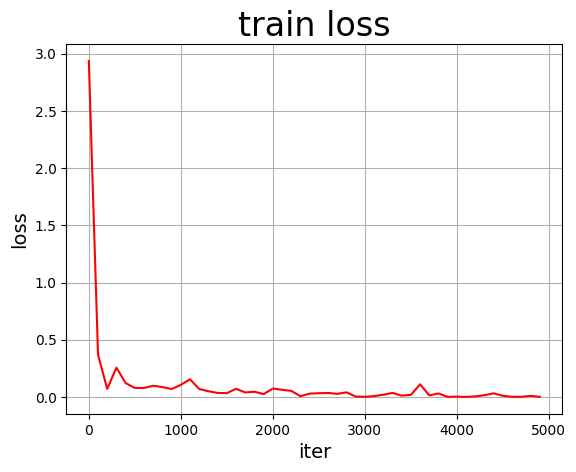

In [8]:
#画出训练过程中Loss的变化曲线
plt.figure()
plt.title("train loss", fontsize=24)
plt.xlabel("iter", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.plot(iters, losses,color='red',label='train loss') 
plt.grid()
plt.show()

## 使用VisualDL可视化分析

VisualDL是飞桨可视化分析工具，以丰富的图表呈现训练参数变化趋势、模型结构、数据样本、高维数据分布等。帮助用户清晰直观地理解深度学习模型训练过程及模型结构，进而实现高效的模型调优，具体代码实现如下。

* 步骤1：引入VisualDL库，定义作图数据存储位置（供第3步使用），本案例的路径是“log”。
```
from visualdl import LogWriter
log_writer = LogWriter("./log")
```
* 步骤2：在训练过程中插入作图语句。当每100个batch训练完成后，将当前损失作为一个新增的数据点(iter和acc的映射对)存储到第一步设置的文件中。使用变量iter记录下已经训练的批次数，作为作图的X轴坐标。

```
log_writer.add_scalar(tag = 'acc', step = iter, value = avg_acc.numpy())
log_writer.add_scalar(tag = 'loss', step = iter, value = avg_loss.numpy())
iter = iter + 100
```

In [9]:
# 安装VisualDL
!pip install --upgrade --pre visualdl

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


In [13]:
#引入VisualDL库，并设定保存作图数据的文件位置
from visualdl import LogWriter
log_writer = LogWriter(logdir="./log")

def train(model):
    model.train()
    
    opt = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    
    EPOCH_NUM = 10
    iter = 0
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程，同时拿到模型输出值和分类准确率
            predicts, avg_acc = model(images, labels)
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 100 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), avg_acc.numpy()))
                log_writer.add_scalar(tag = 'acc', step = iter, value = avg_acc.numpy())
                log_writer.add_scalar(tag = 'loss', step = iter, value = avg_loss.numpy())
                iter = iter + 100

            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
model = MNIST()
train(model)

epoch: 0, batch: 0, loss is: 4.268248558044434, acc is 0.09000000357627869
epoch: 0, batch: 100, loss is: 0.2475145161151886, acc is 0.9300000071525574
epoch: 0, batch: 200, loss is: 0.21958422660827637, acc is 0.9399999976158142
epoch: 0, batch: 300, loss is: 0.18018056452274323, acc is 0.9599999785423279
epoch: 0, batch: 400, loss is: 0.09924077242612839, acc is 0.9800000190734863
epoch: 1, batch: 0, loss is: 0.07932081818580627, acc is 0.9800000190734863
epoch: 1, batch: 100, loss is: 0.10599736124277115, acc is 0.949999988079071
epoch: 1, batch: 200, loss is: 0.026834527030587196, acc is 1.0
epoch: 1, batch: 300, loss is: 0.11744561791419983, acc is 0.9300000071525574
epoch: 1, batch: 400, loss is: 0.07028964161872864, acc is 0.9800000190734863
epoch: 2, batch: 0, loss is: 0.04242385923862457, acc is 0.9900000095367432
epoch: 2, batch: 100, loss is: 0.04738432914018631, acc is 0.9900000095367432
epoch: 2, batch: 200, loss is: 0.06059197336435318, acc is 0.9800000190734863
epoch: 2,

* 步骤3：命令行启动VisualDL。

使用“visualdl --logdir [数据文件所在文件夹路径] 的命令启动VisualDL。在VisualDL启动后，命令行会打印出可用浏览器查阅图形结果的网址。
``` 
$ visualdl --logdir ./log --port 8080
```

* 步骤4：打开浏览器，查看作图结果，如 **图6** 所示。

查阅的网址在第三步的启动命令后会打印出来（如http://127.0.0.1:8080/），将该网址输入浏览器地址栏刷新页面的效果如下图所示。除了右侧对数据点的作图外，左侧还有一个控制板，可以调整诸多作图的细节。


<center><img src="https://ai-studio-static-online.cdn.bcebos.com/c29fdeed4f404eeb846c8c864497f939b5920c3e6fea4f60a9e4ebe4503b6a6b" width="600" hegiht="" ></center>
<center><br>图6：VisualDL作图示例</br></center>
<br></br>


## 作业题

* 将普通神经网络模型的每层输出打印，观察内容。
* 将分类准确率的指标 用PLT库画图表示。
* 通过分类准确率，判断以采用不同损失函数训练模型的效果优劣。
* 作图比较：随着训练进行，模型在训练集和测试集上的Loss曲线。
* 调节正则化权重，观察4的作图曲线的变化，并分析原因。

In [17]:
# 读取一张本地的样例图片，转变成模型输入的格式
def load_image(img_path):
    # 从img_path中读取图像，并转为灰度图
    im = Image.open(img_path).convert('L')
    im = im.resize((28, 28), Image.LANCZOS)
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)
    # 图像归一化
    im = 1.0 - im / 255.
    return im

# 定义预测过程
model = MNIST()
params_file_path = 'mnist.pdparams'
img_path = 'work/example_7.jpg'
# 加载模型参数
param_dict = paddle.load(params_file_path)
model.load_dict(param_dict)
# 灌入数据
model.eval()
tensor_img = load_image(img_path)
#模型反馈10个分类标签的对应概率
results = model(paddle.to_tensor(tensor_img))
#取概率最大的标签作为预测输出
lab = np.argsort(results.numpy())
print("本次预测的数字是: ", lab[0][-1])

本次预测的数字是:  8
